In [1]:
import sys
venv_root = '/var/lib/vz/data/c17000697/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')
import os

os.environ["CUDA_DEVICE_VISIBLE"]="0"

In [2]:
import load_caption

features,texts=load_caption.extract_features_caption(_type='train',save_all=True,pooling=True)
print(features.shape)
print(len(texts))

Using TensorFlow backend.


processed 500
processed 1000
processed 1500
processed 2000
processed 2500
processed 3000
processed 3500
processed 4000
processed 4500
processed 5000
processed 5500
processed 6000
processed 6500
processed 7000
processed 7500
processed 8000
processed 8500
processed 9000
processed 9500
processed 10000
processed 10500
processed 11000
processed 11500
processed 12000
processed 12500
processed 13000
processed 13500
processed 14000
processed 14500
processed 15000
processed 15500
processed 16000
processed 16500
processed 17000
processed 17500
processed 18000
processed 18500
processed 19000
processed 19500
processed 20000
processed 20500
processed 21000
processed 21500
processed 22000
processed 22500
processed 23000
processed 23500
processed 24000
processed 24500
processed 25000
processed 25500
processed 26000
processed 26500
processed 27000
processed 27500
processed 28000
processed 28500
processed 29000
processed 29500
processed 30000
processed 30500
processed 31000
processed 31500
processed 32

In [3]:
import numpy as np
def load(captions_filename, features_filename):
    features = np.load(features_filename)
    images = []
    texts = []
    with open(captions_filename) as fp:
        for line in fp:
            tokens = line.strip().split()
            images.append(tokens[0])
            texts.append(' '.join(tokens[1:]))
    return features, images, texts
features,images,texts=load('../train.captions.txt','../resnet50-features.train.40k.npy')
#print(features.shape)
#print(len(texts))

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
print(len(texts))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
captions = pad_sequences(sequences, maxlen=16)

# It’s the right time to save the vocabulary so that we can reload it later.
vocab = tokenizer.word_index
vocab['<eos>'] = 0

# add word with id 0
import json
with open('vocab.json', 'w') as fp:
    # save the vocab
    fp.write(json.dumps(vocab))

414113


In [5]:
len(vocab)

22679

In [8]:
import embedding


embedding_weights = embedding.load(vocab, 100, '../embeddings/glove.twitter.27B.100d.filtered.txt')

loading embeddings from "../embeddings/glove.twitter.27B.100d.filtered.txt"


In [9]:
def create_tsv(filename):
    print('loading embeddings from "%s"' % filename, file=sys.stderr)
    with open(filename) as fp,open(filename+'_metadata.tsv','w+') as fp3,open(filename+".tsv",'w+') as fp2:
        for line in fp:
            vector = line.strip().split(' ',1)[1]
            tokens = vector.split(' ')
            for i in range(len(tokens)-2):
                fp2.write(tokens[i]+'\t')
            fp2.write(tokens[len(tokens)-1]+'\n')
            fp3.write(line.strip().split(' ',1)[0]+"\n")
#create_tsv('./embeddings/glove.twitter.27B.100d.filtered.txt')

In [10]:
import numpy as np
import json
import keras
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from attention import Attention
from keras.applications.imagenet_utils import preprocess_input

image_input = keras.layers.Input(shape=(2048,))
caption_input = keras.layers.Input(shape=(16,))
noise_input = keras.layers.Input(shape=(16,))

caption_embedding = keras.layers.Embedding(len(vocab), 100, input_length=16, weights=[embedding_weights])
caption_rnn = keras.layers.LSTM(256,return_sequences=True)
image_dense = keras.layers.Dense(256, activation='tanh')

attention = Attention()
image_pipeline = image_dense(image_input)
caption_pipeline = attention(caption_rnn(caption_embedding(caption_input)))
noise_pipeline = attention(caption_rnn(caption_embedding(noise_input)))

positive_pair = keras.layers.dot([image_pipeline, caption_pipeline], axes=1)
negative_pair = keras.layers.dot([image_pipeline, noise_pipeline], axes=1)
output = keras.layers.concatenate([positive_pair, negative_pair])

training_model = keras.models.Model(input=[image_input, caption_input, noise_input], output=output)
image_model = keras.models.Model(input=image_input, output=image_pipeline)
caption_model = keras.models.Model(input=caption_input, output=caption_pipeline)

training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 16, 100)      2267900     input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________

In [11]:
from keras import backend as K

def custom_loss(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.sum(K.maximum(0., 1. - positive + negative))

def accuracy(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.mean(positive > negative)

In [12]:
training_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])

In [17]:
from keras.callbacks import TensorBoard
from time import time
noise = np.copy(captions)
fake_labels = np.zeros((len(features), 1))
X_train = [features[:409113], captions[:409113], noise[:409113]]
Y_train = fake_labels[:409113]
X_valid = [features[-5000:], captions[-5000:], noise[-5000:]]
Y_valid = fake_labels[-5000:]

tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0,write_graph=True, write_images=False)
shuffle_callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda epochs, logs: np.random.shuffle(noise))
nb_epoch = 50

h = training_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], nb_epoch=nb_epoch, batch_size=128, verbose=0,callbacks=[shuffle_callback,tensorboard])

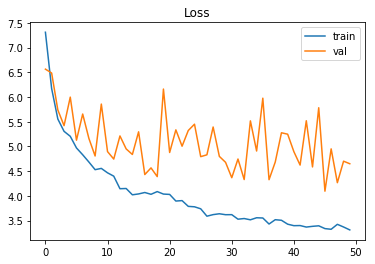

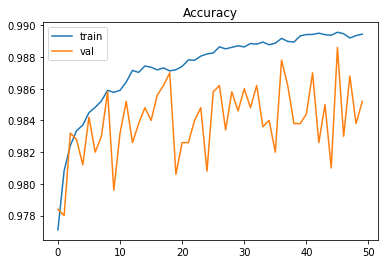

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plt = np.arange(nb_epoch)
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(x_plt, h.history['accuracy'], label='train')
plt.plot(x_plt, h.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.show()

In [19]:
#from imagenet_utils import preprocess_input
resnet_model = ResNet50(weights='imagenet', include_top=False,pooling="avg")
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = resnet_model.predict(x)
    return np.expand_dims(features.flatten(), axis=0)

In [20]:
caption_model.save('model.caption')
np.save('caption-representations',caption_model.predict(captions))

In [21]:
caption_representations = np.load('caption-representations.npy')

In [22]:
def generate_caption(image_filename, n=50):
    image_representation =image_model.predict(extract_features(image_filename))
    scores = np.dot(caption_representations,image_representation.T).flatten()
    indices = np.argpartition(scores, -n)[-n:]
    indices = indices[np.argsort(scores[indices])]
    print(indices)
    for i in [int(x) for x in reversed(indices)]:
        print(scores[i], texts[i])


In [19]:
from keras.models import load_model
training_model.save('training_model.h5')
caption_model.save('caption_model.h5')
image_model.save('image_model.h5')

In [25]:
generate_caption('../data/test2014/COCO_test2014_000000000016.jpg')

[270832 340687 392119 340757 335966 345905 413646 152178  96687   4498
 214243 142781  50596 403934 214305  30124 255458 264159  69634 408921
 240117 413641 383429 281184 214296  19712  53692  84797 347634 214242
  76301 219736 325942  84965 275949  79507 264992 413654  28446 163199
 245021  19660  86545   4488 388680 281236 142770 408972 357846 212830]
7.342305 a man with a baseball glove holding a baseball
7.3317595 a man with a baseball bat in front of a man with a glove
7.3317595 a man with a baseball bat in front of a man with a glove
7.23167 a man with a baseball bat standing in front of a man with a ball
7.101082 a man wearing a baseball glove and holding a baseball
7.090976 a man who is holding a baseball bat playing baseball
7.042645 a person with a baseball bat in the middle of a swing
7.0113516 a man holding a baseball bat an playing baseball
7.0061507 a man with a baseball bat playing baseball
6.9744678 a man playing baseball is preparing to swing his bat at a baseball
6.95